In [1]:
using DataFrames, CSV, GraphPlot, Impute, Plots, Colors, Statistics, Random, Distributions

dir = "../Mariana-Paquete/Mariana-Basefunc/"

include(dir*"funciones_de_red.jl")
include(dir*"objetos.jl")
include(dir*"dinamica_conductores.jl")
include(dir*"animaciones.jl")

plot_digraph (generic function with 1 method)

In [2]:
# Parametros
tamano_red = 5;
doble_sentido = false;
center_h_dist = 0.5;
sd_h_dist = 0;
h_distribution = Normal(center_h_dist, sd_h_dist);
n_cars = 1600;
ti = 0.0;
tf = 150;
max_n_dias = 50;
path_csv = "test.csv";

In [3]:
# Generacion de la red
red_cuadrada = create_square_network(tamano_red, both_ways=doble_sentido);
SqNet= red_cuadrada.digraph;
m = nv(SqNet);
posarr = red_cuadrada.position_array;
city_mt = red_cuadrada.city_matrix;

In [4]:
# Generacion de los autos
autos = generate_autos(m,tamano_red,red_cuadrada,n_cars,ti,tf,h_distribution);

In [5]:
# simulacion
day_simulacion = 0;

while day_simulacion < max_n_dias
    print("día $(day_simulacion) \n")
    times, vels = simulacion!(0., red_cuadrada, autos);
    vels_summ = vels_summary(autos)
    travel_times = times_summary(autos)
    indexes = restart(autos, red_cuadrada)


    df = DataFrame(speeds = [vels_summ],
                times = [travel_times],
                indexes = [indexes]
               )

    CSV.write(path_csv, df, append=true, writeheader = (day_simulacion==0))

    print(minimum(vels_summ)," ", mean(vels_summ),"\n")
    global day_simulacion += 1
end

día 0 
6.933020894356571

 10.955435330665104
día 1 


7.306401775641352 11.185612809709337
día 2 
7.46372637240516

 11.224814665913259
día 3 


7.460544030286068 11.238126449416681
día 4 
7.460544030286068

 11.237199037657215
día 5 


7.368853215327034 11.242325084113272
día 6 
7.368853215327034

 11.242565195670009
día 7 


7.368853215327034 11.242736868516781
día 8 
6.930428234631416

 11.196215558987976
día 9 


7.181867933487675 11.255035599645344
día 10 
7.457951370560911

 11.273046585402335
día 11 


7.463726372405162 11.278926557807168
día 12 
7.647529312125428

 11.287291750292166
día 13 


7.647529312125428 11.287916623498122
día 14 
7.632632075895853

 11.290379629278933
día 15 


7.332797936888902 11.281096792417179
día 16 
7.38347290296371

 11.261101388679648
día 17 


7.181867933487675 11.289987018680472
día 18 
7.540185134066296

 11.294485878774548
día 19 


7.552874019595198 11.30397423959679
día 20 
7.6970692003086825

 11.30668012752706
día 21 


7.6947713817804955 11.305585006693045
día 22 
7.573050844528225

 11.307927754230896
día 23 


7.466041483537419 11.297352008267797
día 24 
7.448517002374548

 11.275281663137143
día 25 


7.181867933487675 11.30693322428071
día 26 
7.538024584295333

 11.305626164042069
día 27 


7.552874019595198 11.31073833885196
día 28 
7.553090645521139

 11.312845565022712
día 29 


7.553090645521139 11.314318822762266
día 30 
7.553090645521139

 11.314186688474202
día 31 


7.466041483537419 11.305063135801001
día 32 
7.445924342649391

 11.258559706418986
día 33 


7.181867933487675 11.3062100227723
día 34 
7.540430580999021

 11.305167516272668
día 35 


7.3688705079311045 11.309123099434387
día 36 
7.650416813047552

 11.311699127053792
día 37 


7.650416813047552 11.313455850758523
día 38 
7.647546604729499

 11.313566984542286
día 39 


7.466041483537419 11.309732960094152
día 40 
7.383767744160679

 11.289092996373096
día 41 


7.181867933487675 11.314708478965963
día 42 
7.647234470928458

 11.313803947952279
día 43 


7.46372637240516 11.311848616803418
día 44 
7.696251649198486

 11.317947836651717
día 45 


7.553133877031317 11.317478071622409
día 46 
7.650434105651622

 11.320040479448298
día 47 


7.466041483537419 11.3145046276573
día 48 
7.463431531208192

 11.29063118293801
día 49 


7.181867933487675 11.319501765796248


# Read the file

In [6]:
reads=CSV.read(path_csv,DataFrame);

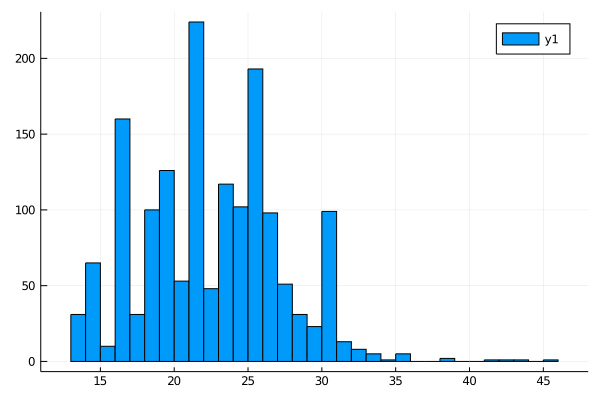

In [9]:
histogram(eval(Meta.parse(reads.times[45])))

In [17]:
mean(eval(Meta.parse(reads.speeds[45])))

11.317947836651717

┌ Info: Saved animation to 
│   fn = /Users/Mariana/Documents/Code-MarianaTesis/code/julia-code/Mariana-Notebooks/vels.gif
└ @ Plots /Users/Mariana/.julia/packages/Plots/XbAWb/src/animation.jl:104


Plots.AnimatedGif("/Users/Mariana/Documents/Code-MarianaTesis/code/julia-code/Mariana-Notebooks/vels.gif")
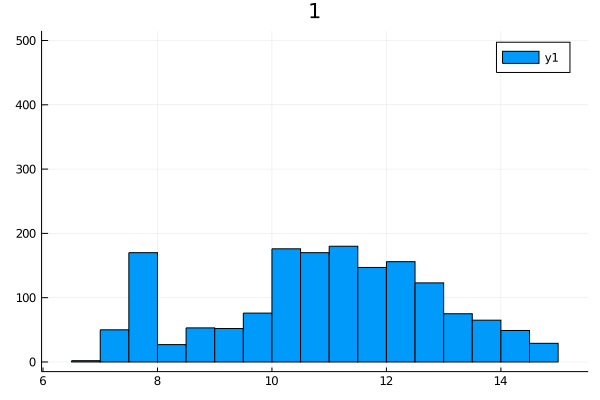

In [14]:
anim = @animate for i in 1:50
    histogram(eval(Meta.parse(reads.speeds[i])),nbins=15,ylim=[0,500],title = string(i))
end

gif(anim, "vels.gif", fps = 2)

In [18]:
mean(eval(Meta.parse(reads.times[45])))

22.479655147870464

┌ Info: Saved animation to 
│   fn = /Users/Mariana/Documents/Code-MarianaTesis/code/julia-code/Mariana-Notebooks/times.gif
└ @ Plots /Users/Mariana/.julia/packages/Plots/XbAWb/src/animation.jl:104


Plots.AnimatedGif("/Users/Mariana/Documents/Code-MarianaTesis/code/julia-code/Mariana-Notebooks/times.gif")
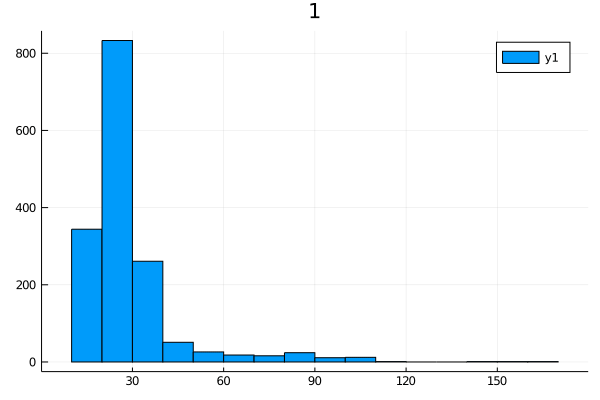

In [16]:
anim = @animate for i in 1:50
    histogram(eval(Meta.parse(reads.times[i])),nbins=15,title = string(i))
end

gif(anim, "times.gif", fps = 2)